# Product Clustering for Recommendation based on Customer Insights, Profiling and Customer Satisfaction

Data Preprocessing and feature extraction for clustering

In [1]:
%%bash
pip install stemming

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stemming: filename=stemming-1.0.1-py3-none-any.whl size=11138 sha256=b4caa2b0d89903d88e7af17de8fa597c9d3e1bf0c65ae50e425e92b246d6428b
  Stored in directory: /root/.cache/pip/wheels/6b/e5/e2/c52ebc0a5b53fd82b00cc385e57bb1c90bd50e5f54ddbc06d1
Successfully built stemming


In [2]:
import string
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from stemming.porter2 import stem
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Open the file to read Amazon Product Metadata

In [4]:
df = open ('/content/drive/MyDrive/BAJAJ/GNN_datasets/amazon-meta.txt', 'r', encoding='utf-8', errors= 'ignore')

# Initialize a nested product dictionary that will hold cleaned up amazon product data. 

In [5]:
amazonProducts= {}

# Read the data from the Amazon file and fill the amazonProducts nested dictionary

In [6]:
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff,helpf,votes) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0,0,0)
for line in df:
    line = line.strip()
    if(line.startswith("Id")):
        Id = line[3:].strip()
        counter = 0
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()
    elif(line.startswith("19")):
        ls = line.split()
        votes=votes+int(ls[6].strip())
        helpf=helpf+int(ls[8].strip())
    elif(line.startswith("20")):
        ls = line.split()
        ls = line.split()
        votes=votes+int(ls[6].strip())
        helpf=helpf+int(ls[8].strip())
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((df.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ',Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif (line==""): # write out fields to amazonProducts dictionary
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['Helpful'] = int(helpf)
            MetaData['Votes'] = int(votes)
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff,helpf,votes) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0,0,0)
df.close

<function TextIOWrapper.close>

Converting Dictionary to df

In [7]:
df = pd.DataFrame.from_dict(amazonProducts)
df = df.T

Unique Groups of Products Available

In [8]:
df.Group.unique()

array(['', 'Book', 'Music', 'DVD', 'Video', 'Toy', 'Video Games',
       'Software', 'Baby Product', 'CE', 'Sports'], dtype=object)

Checking for null data items

In [9]:
df.isnull().sum()

Id              0
Categories      0
Group           0
SalesRank       0
TotalReviews    0
AvgRating       0
Helpful         0
Votes           0
dtype: int64

Checking Distribution of Various Groups of Products

In [10]:
df['Group'].value_counts()

Book            393561
Music           103144
Video            26131
DVD              19828
                  5868
Toy                  8
Software             5
CE                   4
Video Games          1
Baby Product         1
Sports               1
Name: Group, dtype: int64

#**Explaination left.............................**

In [11]:
df = df[(df['Group'] == 'Book') | (df['Group'] == 'Music') | (df['Group'] == 'Video') | (df['Group'] == 'DVD')]

Finding Non-Helpful Votes

In [12]:
df['NonHelpfulVotes']=df['Votes']-df['Helpful']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df['ASIN'] = df.index
df1 = df.set_index('Id')
df1['Helpful'] = df1['Helpful'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Finding and Visualizing Distribution of Helpful Votes

In [14]:
df1['Helpful'].describe()

count    542664.000000
mean         53.096802
std         266.525417
min           0.000000
25%           0.000000
50%           8.000000
75%          35.000000
max       27354.000000
Name: Helpful, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1efe74150>]],
      dtype=object)

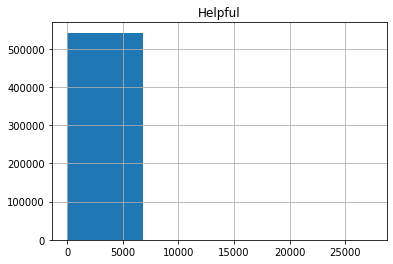

In [15]:
df1.hist(bins=4)

In [16]:
df1=df1.reset_index()

Binning / Categorizing Products into 4 buckets based on customer insights

In [17]:
df1['label_code'] = pd.cut(x=df1['Helpful'], bins=[-1, 8, 35, 27355], labels=['0', '1', '2'])

Visualization of Helpful

In [18]:
df2 = df1[0:100000]
df2['Helpful'].describe()
df2 = df1[100000:200000]
df2['Helpful'].describe()
df2 = df1[200000:300000]
df2['Helpful'].describe()
df2 = df1[300000:400000]
df2['Helpful'].describe()
df2 = df1[400000:]
df2['Helpful'].describe()
df2 = df1[400000:]
df2['AvgRating']=df2['AvgRating'].astype(float)
df2.groupby('AvgRating').count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Id,Categories,Group,SalesRank,TotalReviews,Helpful,Votes,NonHelpfulVotes,ASIN,label_code
AvgRating,,,,,,,,,,
0.0,30920,30920,30920,30920,30920,30920,30920,30920,30920,30920
1.0,803,803,803,803,803,803,803,803,803,803
1.5,250,250,250,250,250,250,250,250,250,250
2.0,1166,1166,1166,1166,1166,1166,1166,1166,1166,1166
2.5,1985,1985,1985,1985,1985,1985,1985,1985,1985,1985
3.0,5995,5995,5995,5995,5995,5995,5995,5995,5995,5995
3.5,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711
4.0,23135,23135,23135,23135,23135,23135,23135,23135,23135,23135
4.5,28547,28547,28547,28547,28547,28547,28547,28547,28547,28547


In [19]:
df2.groupby('label_code').count()

,Id,Categories,Group,SalesRank,TotalReviews,AvgRating,Helpful,Votes,NonHelpfulVotes,ASIN
label_code,,,,,,,,,,
0,68103,68103,68103,68103,68103,68103,68103,68103,68103,68103
1,37031,37031,37031,37031,37031,37031,37031,37031,37031,37031
2,37530,37530,37530,37530,37530,37530,37530,37530,37530,37530


In [20]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df1[['Group']]).toarray())
df1 = df1.join(encoder_df)

In [21]:
df1=df1.drop('Group',axis=1)

In [22]:
df1['label_code']=df1['label_code'].astype(int)

In [23]:
def jaccard(a, b):
    a = set((str(a)).split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [24]:
def prod_label_recomm(x_counter):
  # get label of asin
  df_counter = df1.loc[df1['ASIN'] == x_counter]
  x = int(df_counter['label_code'])
  y = set((str(df_counter['Categories'])).split())
  df_counter = df1.loc[df1['label_code'] == x]
  df_counter = df_counter.loc[df_counter['AvgRating']>=4.5]
  df_counter['score_cat_inter']= df_counter['Categories'].apply(lambda x: jaccard(x,y))
  sorted_df = df_counter.sort_values(["score_cat_inter"], ascending=False)
  return sorted_df[1:6]['ASIN'].tolist()


In [25]:
df1.to_csv("/content/drive/MyDrive/BAJAJ/GNN_datasets/customer_insights_recommendations.csv")

In [26]:
X = prod_label_recomm('B00000AU3R')